In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator model
# class Discriminator(nn.Module):
    # def __init__(self, input_size, hidden_size=128):
    #     super(Discriminator, self).__init__()
    #     self.model = nn.Sequential(
    #         nn.Linear(input_size, hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, 1),
    #         nn.Sigmoid(),
    #     )

    # def forward(self, x):
    #     return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the GAN model
class GAN(nn.Module):
    def __init__(self, input_size_g, output_size_g, input_size_d, hidden_size_d=128):
        super(GAN, self).__init__()
        self.generator = Generator(input_size_g, output_size_g)
        self.discriminator = Discriminator(input_size_d, hidden_size_d)

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
# Custom dataset class
class OdorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data.iloc[idx][["xsrc", "ysrc", "odor", "corrected_u", "corrected_v"]]
        return torch.tensor(sample.values, dtype=torch.float32)

In [18]:
# Load and preprocess data
dir = '~/DataAnalysis/data/Sprints/HighRes/'
data = pd.read_hdf(dir+'Windy/WindyMASigned.h5') # Replace with your data file

new_data=data[:200000]

dataset = OdorDataset(new_data)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=4)

# Initialize GAN, optimizer, and loss function
input_size_g = 4  # xsrc, ysrc, wind_velocity_U, and wind_velocity_V
output_size_g = 1  # New odor measurement
input_size_d = 5  # xsrc, ysrc, odor, wind_velocity_U, and wind_velocity_V

gan = GAN(input_size_g, output_size_g, input_size_d)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan.to(device)
optimizer = optim.Adam(gan.parameters(), lr=0.00002)
criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()

## Train GAN
num_epochs = 100
for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        real_data = real_data.to(device)
        input_gen = real_data[:, [0, 1, 3, 4]]

        with autocast():
            generated_odor = gan.generator(input_gen)
            fake_data = torch.cat((input_gen[:, :2], generated_odor, input_gen[:, 2:]), dim=1)

            real_labels = torch.ones(real_data.size(0), 1).to(device)
            fake_labels = torch.zeros(fake_data.size(0), 1).to(device)

            real_outputs = gan.discriminator(real_data)
            real_loss = criterion(real_outputs, real_labels)

            fake_outputs = gan.discriminator(fake_data.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss

        scaler.scale(d_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        with autocast():
            fake_outputs = gan.discriminator(fake_data)
            g_loss = criterion(fake_outputs, real_labels)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
#         fixed_noise = torch.randn(30, input_size_g).to(device)
#         generated_samples = gan.generator(fixed_noise).detach().cpu().numpy()
#         print(generated_samples)

Epoch [10/100], d_loss: 1.4996252059936523, g_loss: 0.4117968678474426
Epoch [20/100], d_loss: 1.4804154634475708, g_loss: 0.41649922728538513
Epoch [30/100], d_loss: 0.824479877948761, g_loss: 0.6964313387870789
Epoch [40/100], d_loss: 0.8000055551528931, g_loss: 0.6562972664833069
Epoch [50/100], d_loss: 0.7521333694458008, g_loss: 0.6921409368515015
Epoch [60/100], d_loss: 0.7450358271598816, g_loss: 0.6977185010910034
Epoch [70/100], d_loss: 0.7380275130271912, g_loss: 0.7176691889762878
Epoch [80/100], d_loss: 0.7629469037055969, g_loss: 0.7219962477684021
Epoch [90/100], d_loss: 0.737623929977417, g_loss: 0.744795024394989
Epoch [100/100], d_loss: 0.7509304285049438, g_loss: 0.7777993083000183


In [19]:
t_data=data[20000:30000]

test_data = torch.tensor([
    t_data.xsrc.values,
    t_data.ysrc.values,
    t_data.corrected_u.values,
    t_data.corrected_v.values
], dtype=torch.float32).T  # Transpose to have the correct shape



test_data = test_data.to(device) 
generated_odor = gan.generator(test_data)

# Convert generated odor to NumPy array

generated_odor_np = generated_odor.detach().cpu().numpy()

Text(0.5, 1.0, 'Actual')

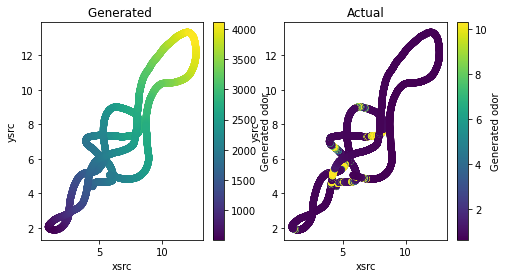

In [20]:
# Get xsrc and ysrc values
xsrc_values = t_data.xsrc.values
ysrc_values = t_data.ysrc.values

f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
# Create a scatter plot
v1 = ax1.scatter(xsrc_values, ysrc_values, c=generated_odor_np, cmap='viridis', marker='o')
f.colorbar(v1, label='Generated odor',ax=ax1)
ax1.set_xlabel('xsrc')
ax1.set_ylabel('ysrc')
ax1.set_title('Generated ')


v2 = ax2.scatter(xsrc_values, ysrc_values, c=t_data.odor, cmap='viridis', marker='o')
f.colorbar(v2, label='Generated odor',ax=ax2)
ax2.set_xlabel('xsrc')
ax2.set_ylabel('ysrc')
ax2.set_title('Actual')


Text(0.5, 1.0, 'Actual')

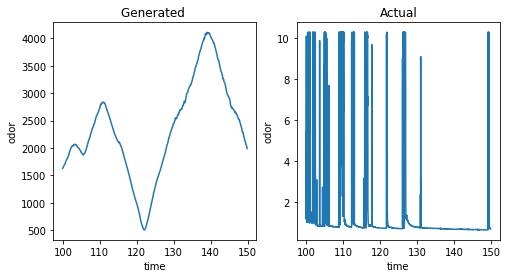

In [21]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
# Create a scatter plot
ax1.plot(t_data.time, generated_odor_np)
ax1.set_xlabel('time')
ax1.set_ylabel('odor')
ax1.set_title('Generated ')


ax2.plot(t_data.time, t_data.odor)

ax2.set_xlabel('time')
ax2.set_ylabel('odor')
ax2.set_title('Actual')
